# Supervised Learning 


- Decision trees with some form of pruning
- Neural networks
- Boosting
- Support Vector Machines
- k-nearest neighbors


## Table of contents <a name="menu"></a>

1. [Data Pre-processing](#dataprocess)
    1. [Label Encoding](#labelencode)
    2. [Scale and change dtype](#scale)
    3. [Splitting the data (no CV)](#split)
2. [Feature Engineering](#featureengi)
    1. [Feature importance](#featureimportance)
3. [Models](#models)
4. [Learning curves for "one-shot" algorithms](#learningcurves)
5. [Cross-validation](#crossval)

In [1]:
import time
import datetime

import copy
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

In [2]:
INPUT_DATA = 'bank_marketing_data/'
TRAIN_CSV = 'bank.csv'

FIG_PATH = 'figures/bank/'

RANDOM_STATE = 17

In [3]:
train_csv = pd.read_csv(INPUT_DATA+TRAIN_CSV)
print(train_csv.shape)
train_csv.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


# Data Pre-processing

In [4]:
features = [col for col in train_csv.columns if col not in ['deposit']]
print(len(features))

16


In [5]:
train_csv['deposit'] = train_csv['deposit'].replace({'no': 0, 'yes':1}).astype(int)
target_values = train_csv['deposit'].values
print(len(target_values))

11162


## Label encoding

In [6]:
non_numerical_features = list(set(features) - set(train_csv._get_numeric_data().columns))
non_num_csv = train_csv[non_numerical_features]
print(non_num_csv.shape)
non_num_csv.head()

(11162, 9)


,job,poutcome,marital,contact,education,housing,loan,default,month
0,admin.,unknown,married,unknown,secondary,yes,no,no,may
1,admin.,unknown,married,unknown,secondary,no,no,no,may
2,technician,unknown,married,unknown,secondary,yes,no,no,may
3,services,unknown,married,unknown,secondary,yes,no,no,may
4,admin.,unknown,married,unknown,tertiary,no,no,no,may


In [7]:
for col in non_numerical_features:
    print(set(non_num_csv[col]))

{'retired', 'student', 'technician', 'services', 'unemployed', 'housemaid', 'entrepreneur', 'self-employed', 'admin.', 'blue-collar', 'unknown', 'management'}
{'unknown', 'other', 'failure', 'success'}
{'divorced', 'married', 'single'}
{'cellular', 'unknown', 'telephone'}
{'secondary', 'tertiary', 'unknown', 'primary'}
{'yes', 'no'}
{'yes', 'no'}
{'yes', 'no'}
{'oct', 'may', 'nov', 'jul', 'aug', 'jan', 'apr', 'feb', 'mar', 'sep', 'jun', 'dec'}


For the columns 'default', 'housing' and 'loan', since we have some yes and no values, we have to attribute no to 0 and yes to 1.
For the others, we can encode the labels as usual.

In [8]:
yes_no_columns = ['default', 'housing', 'loan']
yes_no_features = [x for x in non_numerical_features if x in yes_no_columns]
train_csv[yes_no_features] = train_csv[yes_no_features].replace({'no': 0, 'yes':1}).astype(int)
train_csv[non_numerical_features].head()

,job,poutcome,marital,contact,education,housing,loan,default,month
0,admin.,unknown,married,unknown,secondary,1,0,0,may
1,admin.,unknown,married,unknown,secondary,0,0,0,may
2,technician,unknown,married,unknown,secondary,1,0,0,may
3,services,unknown,married,unknown,secondary,1,0,0,may
4,admin.,unknown,married,unknown,tertiary,0,0,0,may


In [9]:
other_columns = [col for col in non_numerical_features if col not in yes_no_columns]
for col in other_columns:
    label_encod = LabelEncoder()
    label_encod.fit(list(train_csv[col].values))
    train_csv[col] = label_encod.transform(train_csv[col].astype(str))

train_csv[non_numerical_features].head()

,job,poutcome,marital,contact,education,housing,loan,default,month
0,0,3,1,2,1,1,0,0,8
1,0,3,1,2,1,0,0,0,8
2,9,3,1,2,1,1,0,0,8
3,7,3,1,2,1,1,0,0,8
4,0,3,1,2,2,0,0,0,8


### Check NaN values

In [10]:
nan_array = train_csv.isnull().sum().values/train_csv.shape[0]*100
df_nan = pd.DataFrame(nan_array, columns=['Count'], index=train_csv.columns)
df_nan = df_nan.sort_values(by=['Count'], ascending=False)
counter_nan = df_nan[df_nan['Count']>0].shape[0]

print(f'{counter_nan} rows have nan values.')
df_nan.head(10)

0 rows have nan values.


,Count
age,0.0
day,0.0
poutcome,0.0
previous,0.0
pdays,0.0
campaign,0.0
duration,0.0
month,0.0
contact,0.0
job,0.0


## Scale and change dtype

In [11]:
threshold_cate = 25

col_continuous = []
col_categorical = []

for col in features:
    new_col = sorted(list(set(train_csv[col])))
    #print()
    #print(col)
    #print(new_col)
    min_col = np.min(new_col)
    max_col = np.max(new_col)

    if max_col > threshold_cate or col in ['age']:
        col_continuous.append(col)
        continue

    col_categorical.append(col)

In [12]:
train_csv[col_continuous]

,age,balance,day,duration,campaign,pdays,previous
0,59,2343,5,1042,1,-1,0
1,56,45,5,1467,1,-1,0
2,41,1270,5,1389,1,-1,0
3,55,2476,5,579,1,-1,0
4,54,184,5,673,2,-1,0
...,...,...,...,...,...,...,...
11157,33,1,20,257,1,-1,0
11158,39,733,16,83,4,-1,0
11159,32,29,19,156,2,-1,0
11160,43,0,8,9,2,172,5


In [13]:
scaler = StandardScaler()
data2scale = train_csv[col_continuous]
scaler.fit(data2scale)
scaled_cols = scaler.transform(data2scale)
train_csv[col_continuous] = scaled_cols

In [14]:
# Put as int
train_csv[col_categorical] = train_csv[col_categorical].astype('int')

In [15]:
train_csv.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,1.491505,0,1,1,0,0.252525,1,0,2,-1.265746,8,1.930226,-0.554168,-0.481184,-0.36326,3,1
1,1.239676,0,1,1,0,-0.459974,0,0,2,-1.265746,8,3.154612,-0.554168,-0.481184,-0.36326,3,1
2,-0.019470,9,1,1,0,-0.080160,1,0,2,-1.265746,8,2.929901,-0.554168,-0.481184,-0.36326,3,1
3,1.155733,7,1,1,0,0.293762,1,0,2,-1.265746,8,0.596366,-0.554168,-0.481184,-0.36326,3,1
4,1.071790,0,1,2,0,-0.416876,0,0,2,-1.265746,8,0.867171,-0.186785,-0.481184,-0.36326,3,1


## Splitting the data

TODO: 
- Implement Stratified KFold: https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold
- Compare classical Stratified split with Stratified KFold split

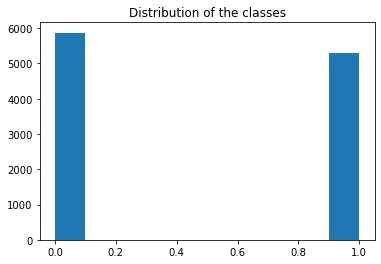

In [16]:
plt.title("Distribution of the classes")
plt.hist(train_csv[['deposit']].values)
plt.show()

In [17]:
training_df, test_df = train_test_split(train_csv, test_size=0.2, random_state=RANDOM_STATE, stratify=train_csv[['deposit']])
train_df, val_df = train_test_split(training_df, test_size=0.2, random_state=RANDOM_STATE, stratify=training_df[['deposit']])

print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (7143, 17)
Validation set shape: (1786, 17)
Test set shape: (2233, 17)


In [18]:
x_training = np.array(training_df[features])
y_training = np.array(training_df['deposit'])

x_train = np.array(train_df[features])
y_train = np.array(train_df['deposit'])

x_val = np.array(val_df[features])
y_val = np.array(val_df['deposit'])

x_test = np.array(test_df[features])
y_test = np.array(test_df['deposit'])

# Models <a name="models"></a>
[Table of Content](#menu)

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [20]:
from itertools import cycle

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc

## Decision Trees

Pruning DT: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

In [130]:
MAX_DEPTH_DT = 9

In [131]:
def train_decision_tree(x_train, y_train, x_test, max_depth=3, random_state=17):
    decision_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    decision_tree.fit(x_train, y_train)
    y_pred_proba_trees = decision_tree.predict_proba(x_test)
    
    return (decision_tree, y_pred_proba_trees)

In [132]:
%%time
decision_tree, y_pred_proba_trees = train_decision_tree(x_train, y_train, x_test, max_depth=MAX_DEPTH_DT, random_state=RANDOM_STATE)
print(f"Overall accuracy: {round(accuracy_score(y_test, decision_tree.predict(x_test))*100,2)}%\n")

Overall accuracy: 80.7%

Wall time: 45.9 ms


## Adaboost (Boosting)

In [133]:
MAX_DEPTH_BOOST = 9
N_ESTIMATORS = 161

In [134]:
def train_adaboost(x_train, y_train, x_test, max_depth=3, n_estimators=100, random_state=17):
    decision_tree_boost = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    adaboost_clf = AdaBoostClassifier(base_estimator=decision_tree_boost, n_estimators=n_estimators)
    adaboost_clf.fit(x_train, y_train)
    y_pred_proba_boost = adaboost_clf.predict_proba(x_test)

    return (adaboost_clf, y_pred_proba_boost)

In [135]:
%%time
adaboost_clf, y_pred_proba_boost = train_adaboost(x_train, y_train, x_test, 
                                                  max_depth=MAX_DEPTH_BOOST, n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
print(f"Overall accuracy: {round(accuracy_score(y_test, adaboost_clf.predict(x_test))*100,2)}%\n")

Overall accuracy: 83.39%

Wall time: 5.2 s


## Support vector Machine

In [178]:
def train_svm(x_train, y_train, x_test, C=1, kernel='rbf',random_state=17):
    svm_model = SVC(C=C, kernel=kernel, random_state=random_state)
    svm_model.fit(x_train, y_train)
    y_pred_svm = svm_model.predict(x_test)

    return (svm_model, y_pred_svm)

In [182]:
%%time
svm_model, y_pred_svm = train_svm(x_train, y_train, x_test, C=1, random_state=RANDOM_STATE)
print(f"Overall accuracy: {round(accuracy_score(y_test, y_pred_svm)*100,2)}%\n")

Overall accuracy: 81.15%

Wall time: 1.45 s


## k-Nearest Neighbors

In [148]:
K_NEIGHB = 7
WEIGHTS = 'distance'

In [149]:
def train_knn(x_train, y_train, x_test, k=3, weights='uniform'):
    knn_model = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knn_model.fit(x_train, y_train)
    y_pred_knn_proba = knn_model.predict(x_test)

    return (knn_model, y_pred_knn_proba)

In [150]:
%%time
knn_model, y_pred_knn_proba = train_knn(x_train, y_train, x_test, k=K_NEIGHB, weights=WEIGHTS)
print(f"Overall accuracy: {round(accuracy_score(y_test, y_pred_knn_proba)*100,2)}%\n")

Overall accuracy: 78.55%

Wall time: 290 ms


## Neural Networks

In order to prevent potential overfitting, we will add dropout for all layers of the network.

To improve training speed, we will also implement batch normalisation at each hidden layer of the network.

Data processing/Training/Plotting code from: https://github.com/brain-bzh/dcase-2020-task1-subtaskB

Model from: https://www.kaggle.com/mburakergenc/ttianic-minimal-pytorch-mlp

In [90]:
#https://www.kaggle.com/mburakergenc/ttianic-minimal-pytorch-mlp
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len(features), 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


### Dataloader for Pytorch

In [91]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, trn_X, trn_y):
        self.trn_X = trn_X
        self.trn_y = trn_y

    def __len__(self):
        return self.trn_X.shape[0]

    def __getitem__(self, idx):
        return self.trn_X[idx,:], self.trn_y[idx]
    
class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, val_X, val_y):
        self.val_X = val_X
        self.val_y = val_y
        
    def __len__(self):
        return self.val_X.shape[0]
        
    def __getitem__(self, idx):
        return self.val_X[idx,:], self.val_y[idx]

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_X, test_y):
        self.test_X = test_X
        self.test_y = test_y
        
    def __len__(self):
        return self.test_X.shape[0]

    def __getitem__(self, idx):
        return self.test_X[idx,:], self.test_y[idx]

In [92]:
def create_dataloaders(x_train, y_train, x_val, y_val, x_test, y_test, device, batch_size):
    trn_X, trn_y = torch.tensor(x_train.astype(np.float32)).to(device), torch.tensor(y_train).to(device).long()
    val_X, val_y = torch.tensor(x_val.astype(np.float32)).to(device), torch.tensor(y_val).to(device).long()
    test_X, test_y = torch.tensor(x_test.astype(np.float32)).to(device), torch.tensor(y_test).to(device).long()
    train_set = TrainDataset(trn_X, trn_y)
    val_set = ValidDataset(val_X, val_y)
    test_set = TestDataset(test_X, test_y)
    dataloaders_length = [len(train_set), len(val_set), len(test_set)]

    trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    validationloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=1)

    dataloaders = {"train": trainloader,
                   "val": validationloader,
                   "test": testloader}

    dataset_sizes = {"train": dataloaders_length[0],
                     "val": dataloaders_length[1],
                     "test": dataloaders_length[2]}

    return (dataloaders, dataset_sizes)

### Training functions for Pytorch

In [93]:
from utils import EarlyStopping, plot_training, plot_cm
from main_training import train_model, test_model

### Training Neural Network (Simple approach) <a name="simple_nn"></a>
[Table of Content](#menu)

[Advanced Approach](#advanced_nn)

In [94]:
DEVICE = 'cpu' #torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

GRAPHS_PATH = FIG_PATH
MODEL_TYPE = "Neural Networks"
SAVING = True

BATCH_SIZE = 64
EPOCHS = 25
LR = 1e-3
EARLYSTOP = False
SCHEDULER = False

In [95]:
dataloaders, dataset_sizes = create_dataloaders(x_train, y_train, x_val, y_val, x_test, y_test, 
                                                device=DEVICE, batch_size=BATCH_SIZE)

In [96]:
model = Net()

###  Define loss function and optimizer ### 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=1e-4) if SCHEDULER else None

# Define dictionary for training info
history_training = {'train_loss': [],
                    'val_loss': [],
                    'train_acc': [],
                    'val_acc': []}


### Training ###
model, history_training = train_model(model=model, hist=history_training, criterion=criterion, 
                                      optimizer=optimizer, dataloaders=dataloaders, dataset_sizes=dataset_sizes, 
                                      scheduler=lr_sched, num_epochs=EPOCHS, estop=EARLYSTOP, device=DEVICE)



**TRAINING**

Epoch 0/24
----------
tensor(5363., dtype=torch.float64) 7144
train Loss: 0.5204 Acc: 0.7507
tensor(1361., dtype=torch.float64) 1785
val Loss: 0.5208 Acc: 0.7625
Epoch complete in 0.3s

Epoch 1/24
----------
tensor(5740., dtype=torch.float64) 7144
train Loss: 0.4460 Acc: 0.8035
tensor(1418., dtype=torch.float64) 1785
val Loss: 0.4627 Acc: 0.7944
Epoch complete in 0.3s

Epoch 2/24
----------
tensor(5800., dtype=torch.float64) 7144
train Loss: 0.4267 Acc: 0.8119
tensor(1424., dtype=torch.float64) 1785
val Loss: 0.4502 Acc: 0.7978
Epoch complete in 0.3s

Epoch 3/24
----------
tensor(5845., dtype=torch.float64) 7144
train Loss: 0.4165 Acc: 0.8182
tensor(1427., dtype=torch.float64) 1785
val Loss: 0.4438 Acc: 0.7994
Epoch complete in 0.3s

Epoch 4/24
----------
tensor(5862., dtype=torch.float64) 7144
train Loss: 0.4101 Acc: 0.8205
tensor(1438., dtype=torch.float64) 1785
val Loss: 0.4422 Acc: 0.8056
Epoch complete in 0.3s

Epoch 5/24
----------
tensor(5883., dtype=torch.float6

In [97]:
### Testing ###
history_training = test_model(model=model, hist=history_training, criterion=criterion, 
                              dataloaders=dataloaders, dataset_sizes=dataset_sizes, device=DEVICE)



**TESTING**


Test stats -  Loss: 0.4428 Acc: 81.10%
Inference on Testset complete in 0.6s



Training graph saved at figures/bank/Neural Networks_losses&acc_bank_marketing_data_testAcc=0.811.png


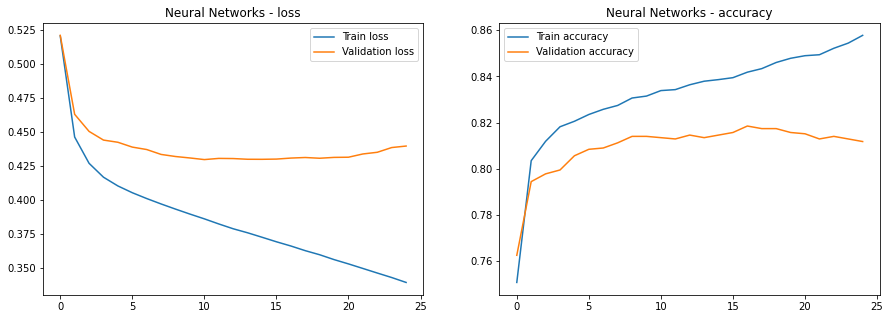

In [98]:
### Plotting the losses ###
plot_training(hist=history_training, graphs_path=GRAPHS_PATH, 
              model_type=MODEL_TYPE, do_save=SAVING, input_data=INPUT_DATA[:-1])

Confusion Matrix saved at figures/bank/Neural Networks_CM_bank_marketing_data_testAcc=0.811.png


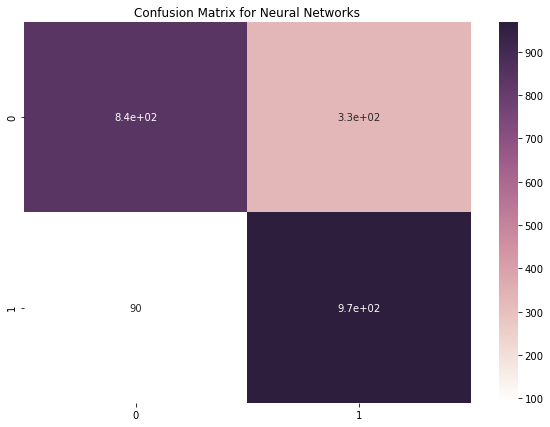

In [99]:
### Plotting the CM ###
plot_cm(hist=history_training, graphs_path=GRAPHS_PATH, 
              model_type=MODEL_TYPE, do_save=SAVING, input_data=INPUT_DATA[:-1])

# Learning curves for "one-shot" algorithms <a name="learningcurves"></a>
[Table of Content](#menu)

In [42]:
def take_samples(x, percent):
    length_x = len(x)
    indexes = np.arange(length_x)
    new_indexes = random.choices(indexes, k=int(percent*length_x))
    new_x = x[new_indexes]

    return new_x


def plot_training_size_variation(model, x_train, y_train, x_test, y_test, graphs_path, do_save=True, do_plot=False, iterations=20):
    percentages = np.linspace(0.05, 1, iterations)

    hist = {'percentages': percentages}
    hist_acc_train = []
    hist_acc_test = []
    hist_f1_train = []
    hist_f1_test = []

    for percent in percentages:
        x_train_perc = take_samples(x_train, percent)
        y_train_perc = take_samples(y_train, percent)
        x_test_perc = x_test
        y_test_perc = y_test

        if model == "dt":
            model_clf, _ = train_decision_tree(x_train_perc, y_train_perc, x_test_perc, 
                                                          max_depth=MAX_DEPTH_DT, random_state=RANDOM_STATE)

        elif model == "adab":
            model_clf, _ = train_adaboost(x_train_perc, y_train_perc, x_test_perc, 
                                                     max_depth=MAX_DEPTH_BOOST, n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)

        elif model == "svm":
            model_clf, _ = train_svm(x_train_perc, y_train_perc, x_test_perc, 
                                                random_state=RANDOM_STATE)

        elif model == "knn":
            model_clf, _ = train_knn(x_train_perc, y_train_perc, x_test_perc, k=K_NEIGHB, weights=WEIGHTS)

        # Score
        y_pred_train = model_clf.predict(x_train_perc)
        y_pred_test = model_clf.predict(x_test_perc)

        acc_train = accuracy_score(y_train_perc, y_pred_train)
        acc_test = accuracy_score(y_test_perc, y_pred_test)
        hist_acc_train.append(acc_train)
        hist_acc_test.append(acc_test)
        
        f1_train = f1_score(y_train_perc, y_pred_train, average='macro')
        f1_test = f1_score(y_test_perc, y_pred_test, average='macro')
        hist_f1_train.append(f1_train)
        hist_f1_test.append(f1_test)

    hist['acc_train'] = hist_acc_train
    hist['acc_test'] = hist_acc_test
    hist['f1_train'] = hist_f1_train
    hist['f1_test'] = hist_f1_test

    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title(f'{model} - learning curves accuracy')
    ax[0].plot(hist["percentages"], hist["acc_train"], label="Training Accuracy")
    ax[0].plot(hist["percentages"], hist["acc_test"], label="Test Accuracy")
    ax[0].legend()
    ax[1].set_title(f'{model} - learning curves f1 score')
    ax[1].plot(hist["percentages"], hist["f1_train"], label="Training macro F1 score")
    ax[1].plot(hist["percentages"], hist["f1_test"], label="Test macro F1 score")
    ax[1].legend()
    if do_save:
        save_graph_path = f"{graphs_path}{model}_acc&f1_{INPUT_DATA[:-1]}.png"
        plt.savefig(save_graph_path)
        print(f"Training graph saved at {save_graph_path}")
    if do_plot: plt.show()

Training graph saved at figures/bank/dt_acc&f1_bank_marketing_data.png


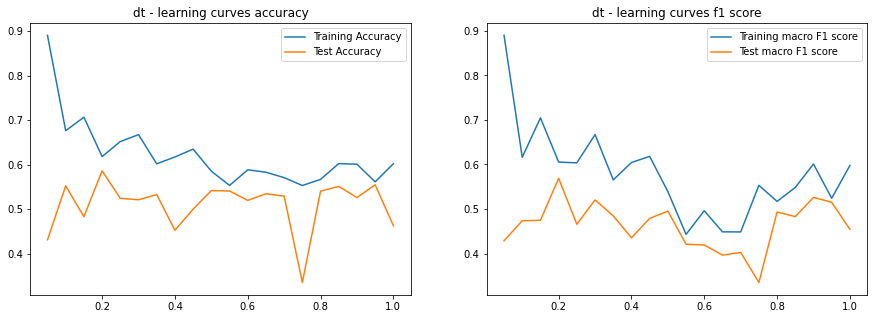

Wall time: 722 ms


In [43]:
%%time
plot_training_size_variation('dt', x_train, y_train, x_test, y_test, graphs_path=GRAPHS_PATH, do_save=True, do_plot=True, iterations=20)

Training graph saved at figures/bank/adab_acc&f1_bank_marketing_data.png


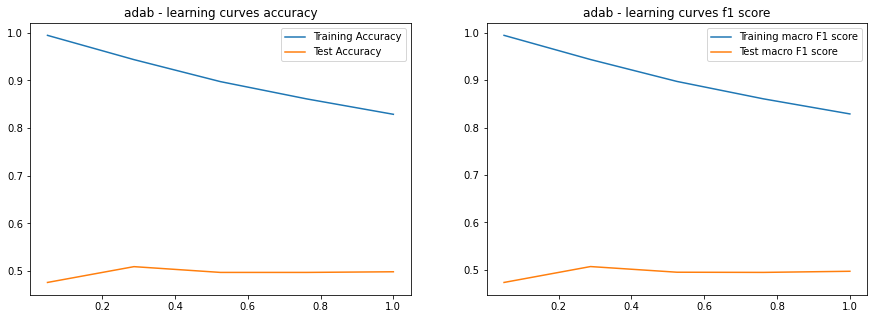

Wall time: 5.65 s


In [44]:
%%time
plot_training_size_variation('adab', x_train, y_train, x_test, y_test, graphs_path=GRAPHS_PATH, do_save=True, do_plot=True, iterations=5)

Training graph saved at figures/bank/svm_acc&f1_bank_marketing_data.png


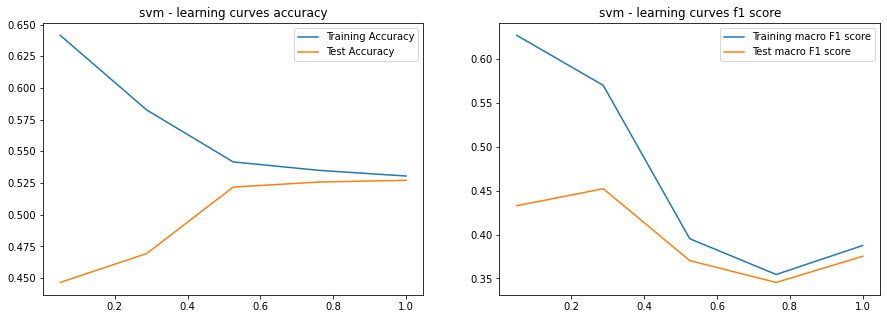

Wall time: 8.64 s


In [45]:
%%time
plot_training_size_variation('svm', x_train, y_train, x_test, y_test, graphs_path=GRAPHS_PATH, do_save=True, do_plot=True, iterations=5)

Training graph saved at figures/bank/knn_acc&f1_bank_marketing_data.png


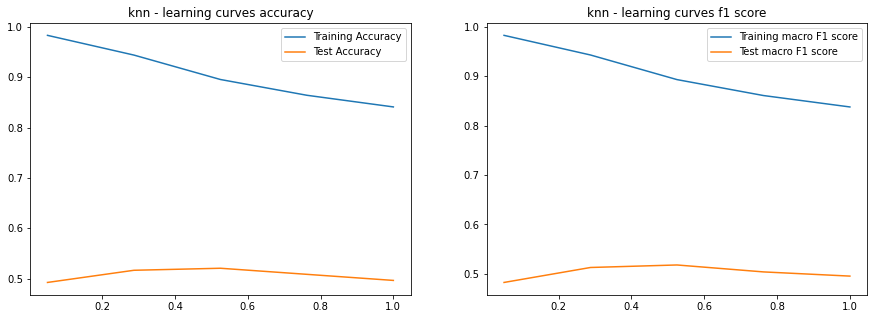

Wall time: 2.52 s


In [46]:
%%time
plot_training_size_variation('knn', x_train, y_train, x_test, y_test, graphs_path=GRAPHS_PATH, do_save=True, do_plot=True, iterations=5)

# Cross-validation <a name="crossval"></a>
[Table of Content](#menu)

Stratified-KFold: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold 

https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6

In [47]:
K_folds = 5

skf = StratifiedKFold(n_splits=K_folds, random_state=RANDOM_STATE)
skf.get_n_splits(x_training, y_training)
print(skf)

StratifiedKFold(n_splits=5, random_state=17, shuffle=False)


D:\ProgramData\Anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [48]:
for train_index, test_index in skf.split(x_training, y_training):
    x_train, x_val = x_training[train_index], x_training[test_index]
    y_train, y_val = y_training[train_index], y_training[test_index]

## Cross-validation on Decision Trees

Best = 9

In [49]:
# https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
from sklearn.model_selection import cross_val_score

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    save_graph_path = f"{GRAPHS_PATH}{'dt'}_cv.png"
    plt.savefig(save_graph_path)

In [50]:
%%time
# fitting trees of depth 1 to 49, step=2
sm_tree_depths = range(1, 50, 2)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(x_training, y_training, sm_tree_depths)

Wall time: 5.15 s


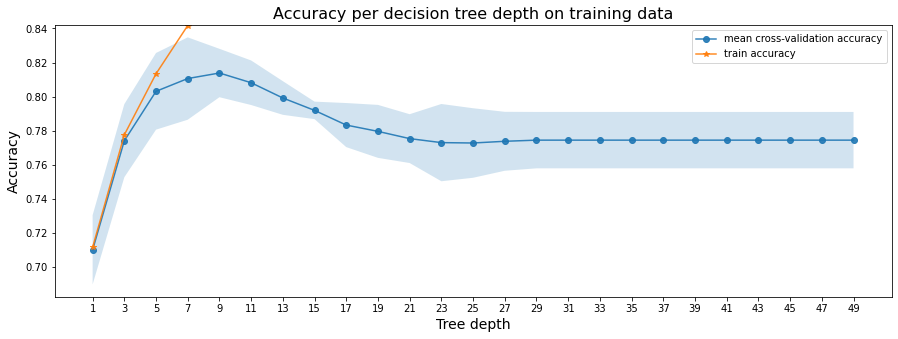

In [51]:
# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

## Cross-validation on AdaBoost

Best = 161

In [52]:
def run_cross_validation_on_adaboost(X, y, nb_estimators, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for nb in nb_estimators:
        decision_tree_boost = DecisionTreeClassifier(max_depth=9, random_state=RANDOM_STATE)
        adaboost_clf = AdaBoostClassifier(base_estimator=decision_tree_boost, n_estimators=nb)
        cv_scores = cross_val_score(adaboost_clf, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(adaboost_clf.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_adaboost(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title, save=False):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('estimators', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    save_graph_path = f"{GRAPHS_PATH}{'adaboost'}_cv.png"
    if save: plt.savefig(save_graph_path)

In [68]:
%%time
# fitting trees of depth 1 to 49, step=2
sm_estimators = range(1, 202, 20)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_adaboost(x_training, y_training, sm_estimators)

Wall time: 3min 41s


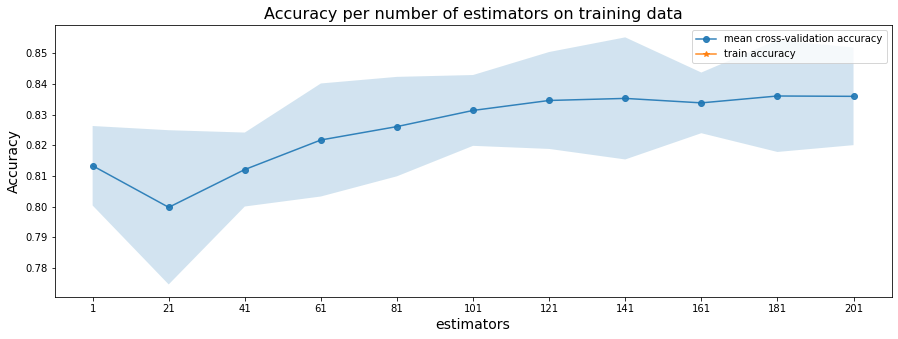

In [71]:
# plotting accuracy
plot_cross_validation_on_adaboost(sm_estimators, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per number of estimators on training data', save=False)

## Cross-validation on SVM

best C = 10

In [175]:
def run_cross_validation_on_svm(X, y, list_kernels, C_list, gamma_list, cv=5, scoring='accuracy'):
    dict_kernels = {}
    for kernel in list_kernels:
        cv_scores_list = []
        cv_scores_std = []
        cv_scores_mean = []
        accuracy_scores = []
        for C in C_list:
            svm_model = SVC(C=C, random_state=RANDOM_STATE)
            cv_scores = cross_val_score(svm_model, X, y, cv=cv, scoring=scoring)
            cv_scores_list.append(cv_scores)
            cv_scores_mean.append(cv_scores.mean())
            cv_scores_std.append(cv_scores.std())
            accuracy_scores.append(svm_model.fit(X, y).score(X, y))
        cv_scores_mean = np.array(cv_scores_mean)
        cv_scores_std = np.array(cv_scores_std)
        accuracy_scores = np.array(accuracy_scores)

        dict_kernels[kernel] = [cv_scores_mean, cv_scores_std, accuracy_scores]
    
    return dict_kernels
  
# function for plotting cross-validation results
def plot_cross_validation_on_svm(depths, dict_kernels, title, save=False):
    fig, ax = plt.subplots(1, len(dict_kernels), figsize=(15,5))
    for idx, kernel in enumerate(dict_kernels.keys()):
        cv_scores_mean, cv_scores_std, accuracy_scores = dict_kernels[kernel]
        
        axis_C = np.arange(len(depths))
        
        ax[idx].plot(axis_C, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.75)
        ax[idx].fill_between(axis_C, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.15)
        ylim = plt.ylim()
        ax[idx].plot(axis_C, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
        ax[idx].set_title(title+f' for {kernel}', fontsize=16)
        ax[idx].set_xlabel('C', fontsize=14)
        ax[idx].set_ylabel('Accuracy', fontsize=14)
        ax[idx].set_ylim(ylim)
        ax[idx].set_xticks(axis_C)
        ax[idx].legend()
    save_graph_path = f"{GRAPHS_PATH}{'svm'}_cv.png"
    if save: plt.savefig(save_graph_path)

In [176]:
%%time
# fitting trees of depth 1 to 49, step=2
list_kernels = ['rbf', 'poly']
C_list = [1, 10, 100]
gamma_list = ['scale']
dict_kernels = run_cross_validation_on_svm(x_training, y_training, list_kernels, C_list, gamma_list)

Wall time: 1min 21s


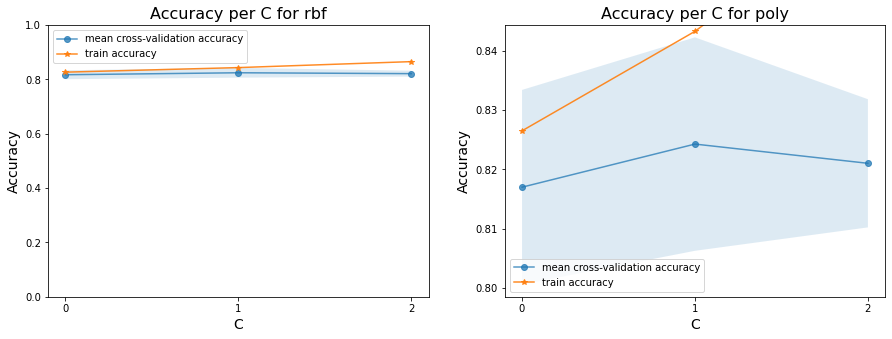

In [183]:
# plotting accuracy
plot_cross_validation_on_svm(C_list, dict_kernels, 
                               'Accuracy per C', save=True)

## Cross-validation on K-NN

Best K = 7

In [55]:
def run_cross_validation_on_knn(X, y, kneighbors, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for k in kneighbors:
        knn_model = KNeighborsClassifier(n_neighbors=k, weights='distance')
        cv_scores = cross_val_score(knn_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(knn_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_knn(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('K', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    save_graph_path = f"{GRAPHS_PATH}{'knn'}_cv.png"
    plt.savefig(save_graph_path)

In [56]:
%%time
# fitting trees of depth 1 to 49, step=2
sm_kneighbors = range(1, 15, 2)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_knn(x_training, y_training, sm_kneighbors)

Wall time: 13 s


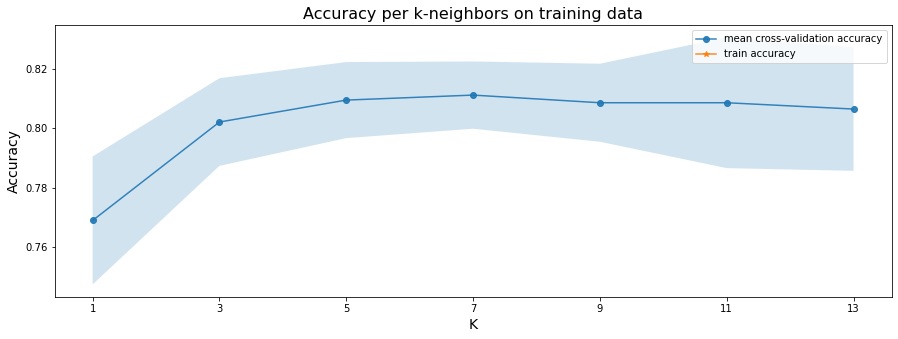

In [57]:
# plotting accuracy
plot_cross_validation_on_knn(sm_kneighbors, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per k-neighbors on training data')

## A better Neural Network (Advanced approach) <a name="advanced_nn"></a>
[Table of Content](#menu) 

[Simple Approach](#simple_nn)

In [124]:
GRAPHS_PATH = FIG_PATH
MODEL_TYPE = "Neural Networks"
SAVING = True

BATCH_SIZE = 64
EPOCHS = 400
LR = 5e-4
EARLYSTOP = True
SCHEDULER = True

In [125]:
#https://www.kaggle.com/mburakergenc/ttianic-minimal-pytorch-mlp
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(len(features), 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=16, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [126]:
model = Net2()

###  Define loss function and optimizer ### 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=1e-4) if SCHEDULER else None

# Define dictionary for training info
history_training = {'train_loss': [],
                    'val_loss': [],
                    'train_acc': [],
                    'val_acc': []}


### Training ###
model, history_training = train_model(model=model, hist=history_training, criterion=criterion, 
                                      optimizer=optimizer, dataloaders=dataloaders, dataset_sizes=dataset_sizes, 
                                      scheduler=lr_sched, num_epochs=EPOCHS, estop=EARLYSTOP, patience_es=15,device=DEVICE)



**TRAINING**

Epoch 0/399
----------
tensor(4737., dtype=torch.float64) 7144
train Loss: 0.6057 Acc: 0.6631
tensor(1391., dtype=torch.float64) 1785
val Loss: 0.4967 Acc: 0.7793
Epoch complete in 0.4s

Validation loss decreased (inf --> 0.496657).  Saving model ...
Epoch 1/399
----------
tensor(5345., dtype=torch.float64) 7144
train Loss: 0.5227 Acc: 0.7482
tensor(1414., dtype=torch.float64) 1785
val Loss: 0.4611 Acc: 0.7922
Epoch complete in 0.3s

Validation loss decreased (0.496657 --> 0.461149).  Saving model ...
Epoch 2/399
----------
tensor(5501., dtype=torch.float64) 7144
train Loss: 0.4887 Acc: 0.7700
tensor(1437., dtype=torch.float64) 1785
val Loss: 0.4425 Acc: 0.8050
Epoch complete in 0.3s

Validation loss decreased (0.461149 --> 0.442488).  Saving model ...
Epoch 3/399
----------
tensor(5543., dtype=torch.float64) 7144
train Loss: 0.4777 Acc: 0.7759
tensor(1440., dtype=torch.float64) 1785
val Loss: 0.4326 Acc: 0.8067
Epoch complete in 0.3s

Validation loss decreased (0.44248

In [127]:
### Testing ###
history_training = test_model(model=model, hist=history_training, criterion=criterion, 
                              dataloaders=dataloaders, dataset_sizes=dataset_sizes, device=DEVICE)



**TESTING**


Test stats -  Loss: 0.3976 Acc: 82.67%
Inference on Testset complete in 0.7s



Training graph saved at figures/bank/Neural Networks_losses&acc__testAcc=0.8267.png


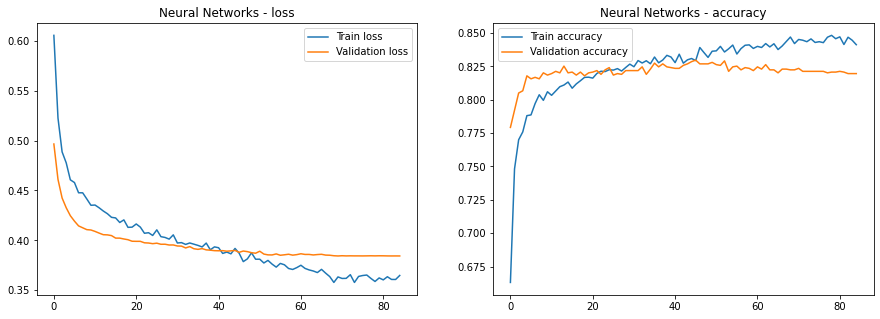

In [128]:
### Plotting the losses ###
plot_training(hist=history_training, graphs_path=GRAPHS_PATH, 
              model_type=MODEL_TYPE, do_save=SAVING)

Confusion Matrix saved at figures/bank/Neural Networks_CM__testAcc=0.8267.png


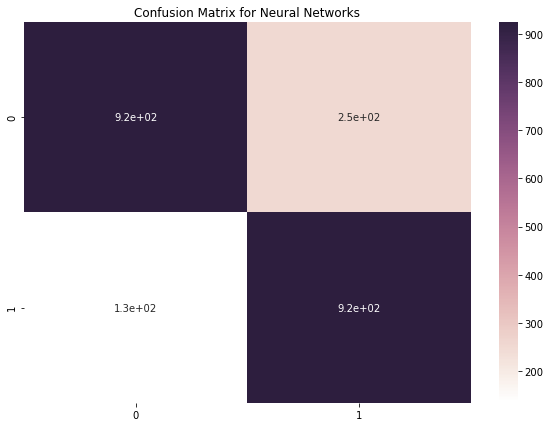

In [129]:
### Plotting the CM ###
plot_cm(hist=history_training, graphs_path=GRAPHS_PATH, 
              model_type=MODEL_TYPE, do_save=SAVING)

# ROC results

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#receiver-operating-characteristic-roc

Implement Macro F1

In [63]:
nb_classes = len(set(train_csv['deposit']))

def plot_ROC(y_test, y_pred_proba, model_name="model_name"):
    print(f"==============\n{model_name}\n==============\n")

    # Adapt array for sklearn's ros function
    y_score = np.where(y_pred_proba[:,1] > 0.5, 1, 0)

    # ROC values
    fp_rate, tp_rate, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fp_rate, tp_rate)

    y_pred = np.array([np.argmax(x) for x in y_pred_proba])
    print(f"Overall accuracy: {round(accuracy_score(y_test, y_pred)*100,2)}%\n")

    plt.plot(fp_rate, tp_rate, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'Receiver operating characteristic for {model_name}')
    plt.legend(loc = 'lower right')
    plt.savefig(FIG_PATH+f'{model_name}.pdf')

    plt.show()

decision_trees

Overall accuracy: 79.89%



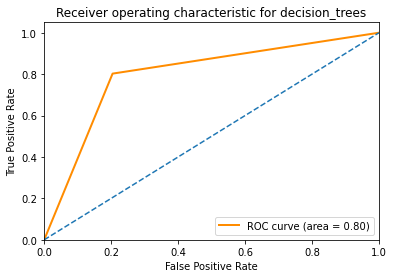

In [64]:
plot_ROC(y_test, y_pred_proba_trees, model_name="decision_trees")

adaboost

Overall accuracy: 80.92%



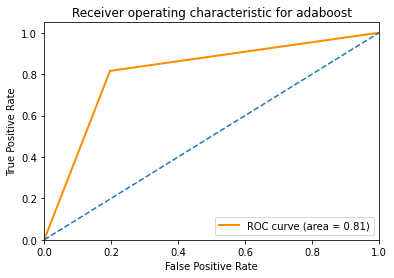

In [65]:
plot_ROC(y_test, y_pred_proba_boost, model_name="adaboost")